# 微调
一个计算机是视觉的模型，除了最后一层的softmax分类，前面的层基本都在做特征提取，因此前面的层的参数的初始化可以通过对现成的参数进行微调
预训练指的是在ImageNet这种著名的数据集进行训练，来测试模型的性能

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

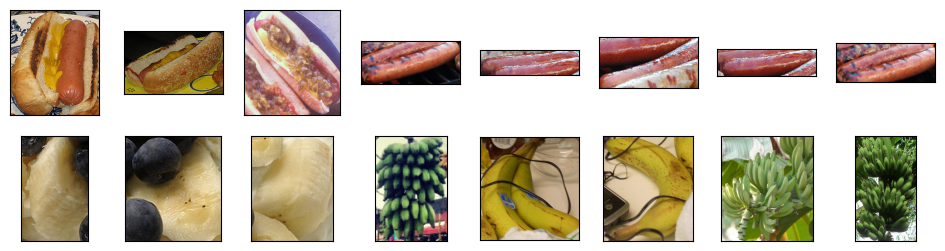

In [1]:
import os
import torch
import torchvision
from torch import nn
import My_utils
import matplotlib.pyplot as plt

train_imgs = torchvision.datasets.ImageFolder('./hotdog/train')
test_imgs = torchvision.datasets.ImageFolder('./hotdog/test')

# 从后往前是反例，从前往后是正例
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
My_utils.show_image(hotdogs + not_hotdogs, 2, 8)

## 图像增广

In [2]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # 对图像进行随机的裁剪，最后resize到224*224
    torchvision.transforms.RandomHorizontalFlip(), # 随机水平翻转
    torchvision.transforms.ToTensor(), # 图片是png格式的，要转换为tensor
    normalize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224), # 从中心裁剪处224*224的图片
    torchvision.transforms.ToTensor(),
    normalize
])

## 下载ResNet的预训练模型

In [3]:
pre_trained_net = torchvision.models.resnet18(pretrained=True)
pre_trained_net

C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
finetune_net = torchvision.models.resnet18(pre_trained_net)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight) # 只需要初始化最后一层的参数

C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Parameter containing:
tensor([[-0.0798, -0.1040,  0.0528,  ...,  0.0707,  0.0938,  0.0629],
        [ 0.0269,  0.0858, -0.0226,  ...,  0.0933,  0.0257,  0.0743]],
       requires_grad=True)

loss 0.071, train_acc 0.975, test_acc 0.960
('416.8 examples/sec on ', "[device(type='cuda', index=0)]")


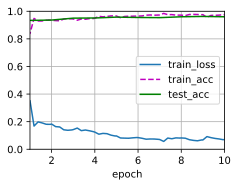

In [5]:
batch_size, num_epochs, learning_rate = 128, 10, 5e-5
train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./hotdog/train', transform=train_augs), batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./hotdog/test', transform=test_augs), batch_size=batch_size, shuffle=True)
trainer = torch.optim.Adam
My_utils.train_fine_tuning(finetune_net, train_iter, test_iter, trainer, num_epochs, learning_rate)